In [96]:
import requests
import json
from langchain import vectorstores, document_loaders, embeddings, chat_models, chains, prompts
import numpy as np
import matplotlib.pyplot as plt
import faiss  # Ensure faiss is imported
from dotenv import load_dotenv
import os
from langchain import vectorstores, document_loaders, embeddings, chat_models, chains, prompts
from langchain.vectorstores import FAISS
import matplotlib.pyplot as plt

from langchain_community.embeddings import OpenAIEmbeddings


# Replace 'vik-gpt-core' with the name of your Solr core
ada_faiss = "../faiss_db/faiss-db-bench"
new_faiss = "../faiss_db/faiss-db-bench-3-large"
ada_embedding_model = 'text-embedding-ada-002'
new_embedding_model = 'text-embedding-3-large'
gpt3_model_name = 'gpt-3.5-turbo-1106'

core_name = "vik-gpt-core"
solr_url = f"http://localhost:8983/solr/{core_name}/select"

path_to_test_set = "./tad-qa-dataset/one-course-dataset.json"
path_to_test_set_difficult = "./tad-qa-dataset/one-course-dataset-difficult.json"

llm_gpt3 = chat_models.ChatOpenAI(model_name=gpt3_model_name, temperature=0.0)
embeddings_ada = OpenAIEmbeddings(model=ada_embedding_model)
embeddings_new = OpenAIEmbeddings(model=new_embedding_model)

vectorstore_ada = FAISS.load_local(ada_faiss, embeddings_ada, allow_dangerous_deserialization=True)
vectorstore_new = FAISS.load_local(new_faiss, embeddings_new, allow_dangerous_deserialization=True)

solr_color = '#8bd7b3'
solr_llm_color = '#17af68'
embed_color = '#77ace9'
embed_color_new = '#a7bcf9'

with open(path_to_test_set, "r", encoding="utf-8") as f:
    test_set = json.load(f)

def get_title(tad):
    try:
        return tad.split('\n')[0].split('-')[1].strip()
    except Exception:
        return ""

In [97]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate

qa = PromptTemplate.from_template(
    template=(
        'Your task is to extract the keywords of the user query and optionally add keywords if you find them relevant.'
        'Make sure it is in Hungarian, use at most 3 keywords'
        'Example: Milyen játékelméletről szóló tárgyak vannak?'
        'Output: játékelmélet, nash egyensúly, fogolydilemma'
        'Task: {query}'
        'Output:'
    )
)
chain = qa | llm_gpt3

In [98]:
params = {
    "q": "analizis",
    "defType": "edismax",
    "qf": "page_content_t",
    "wt": "json",
    "rows": 10,  # Request the maximum rows once
}
response = requests.get(solr_url, params=params)
if response.status_code == 200:
    response_json = response.json()
    documents = response_json.get("response", {}).get("docs", [])
response_json

{'responseHeader': {'status': 0,
  'QTime': 3,
  'params': {'q': 'analizis',
   'defType': 'edismax',
   'qf': 'page_content_t',
   'rows': '10',
   'wt': 'json'}},
 'response': {'numFound': 1,
  'start': 0,
  'numFoundExact': True,
  'docs': [{'id': 'b1303732-08a0-405d-af63-4c97ad13d5eb',
    'data_type_s': 'tad_page',
    'source_s': 'https://portal.vik.bme.hu/kepzes/targyak/TE110909/',
    'page_content_t': 'BME VIK - Fizikai problémák megoldása villamosmérnökök számára 3\nBudapest University of Technology and Economics, Faculty of Electrical Engineering and Informatics\nFizikai problémák megoldása villamosmérnökök számára 3\nBelépés\ncímtáras azonosítással\ntantárgyi adatlapok\nmagyar nyelvű adatlap\nvissza a tantárgylistához\nnyomtatható verzió\nFizikai problémák megoldása villamosmérnökök számára 3\nA tantárgy angol neve: Physics in Practice for Electrical Engineers 3\nAdatlap utolsó módosítása: 2006. július 1.\nBudapesti Műszaki és Gazdaságtudományi Egyetem\nVillamosmérnöki és I

In [72]:
text = response_json.get("response", {}).get("docs", [])[0]['page_content_t']
get_title(text)

'Fizikai problémák megoldása villamosmérnökök számára 3'

In [73]:
results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        query = question["question"]
        params = {
            "q": query,
            "defType": "edismax",
            "qf": "page_content_t",
            "wt": "json",
            "rows": 10,  # Request the maximum rows once
        }
        response = requests.get(solr_url, params=params)
        if response.status_code == 200:
            response_json = response.json()
            documents = response_json.get("response", {}).get("docs", [])
            titles = [get_title(doc['page_content_t']) for doc in documents]
            
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1

accuracies_solr_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        query = question["question"]
        docs = vectorstore_ada.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
        titles = [get_title(doc.page_content) for doc in docs]
        for n in range(1, 11):
            if title_target in titles[:n]:
                results[n]['correct'] += 1
            results[n]['total'] += 1

accuracies_embed_ada_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        query = question["question"]
        docs = vectorstore_new.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
        titles = [get_title(doc.page_content) for doc in docs]
        for n in range(1, 11):
            if title_target in titles[:n]:
                results[n]['correct'] += 1
            results[n]['total'] += 1

accuracies_embed_new_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    for question in example["questions"]:
        #  for query in [, ]:
        params = {
            "q": chain.invoke({'query': question["question"]}).content,
            "defType": "edismax",
            "qf": "page_content_t",
            "wt": "json",
            "rows": 10,  # Request the maximum rows once
        }
        response = requests.get(solr_url, params=params)
        if response.status_code == 200:
            response_json = response.json()
            documents = response_json.get("response", {}).get("docs", [])
            titles = [get_title(doc['page_content_t']) for doc in documents]
            
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1
    
accuracies_solr_llm_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]


In [74]:
# import matplotlib.pyplot as plt
# import numpy as np 

# N_DOCS = 10
# plt.figure(figsize=(12, 8), facecolor='white')
# n_documents = np.arange(1, N_DOCS+1)  # Array from 1 to 10 for the x-axis

# bar_width = 0.30  # Adjusted for 3 bars
# positions_embed = n_documents - bar_width  # Left bar
# positions_solr = n_documents  # Middle bar
# positions_solr_llm = n_documents + bar_width  # Right bar
# plt.figure(figsize=(12, 8), facecolor='white')

# plt.bar(positions_solr, accuracies_solr_easy, width=bar_width, color='#fba7b3', edgecolor='black', linewidth=1, alpha=1,label='Solr')
# plt.bar(positions_embed, accuracies_embed_ada_easy, width=bar_width, color='#8bd7b3', edgecolor='black', linewidth=1, alpha=1, label='Embed ada')
# plt.bar(positions_solr_llm, accuracies_embed_new_easy, width=bar_width,color='#a7b3fb', edgecolor='black', linewidth=1, alpha=1,label='Embed new')

# plt.title('Comparison of Different Loss Functions (Easy)', fontsize=22, fontweight='bold', color='black')
# plt.xlabel('Top N Documents', fontsize=18, color='black')
# plt.ylabel('Accuracy', fontsize=18, color='black')

# plt.xticks(n_documents, fontsize=12, color='black')
# plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, color='black')

# plt.legend(fontsize=16)  # Show legend to identify the bars
# plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
# plt.show()


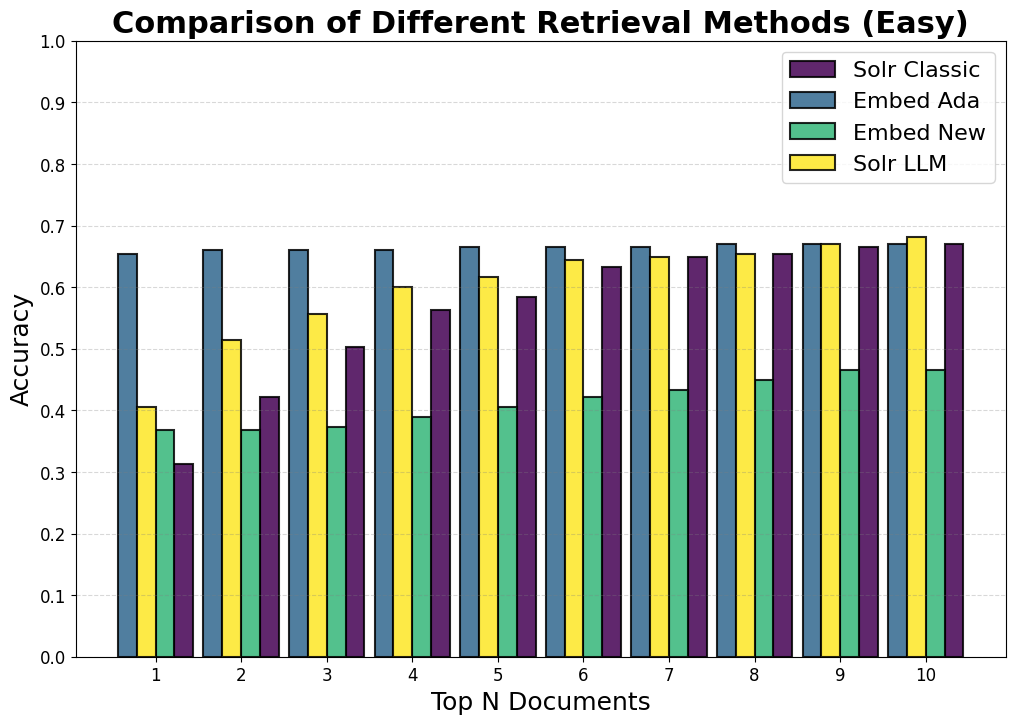

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracies(N_DOCS, accuracies_solr, accuracies_embed_ada, accuracies_embed_new, accuracies_solr_llm, title='Easy'):
    # Generate colors from the viridis colormap
    cmap = plt.get_cmap('viridis')
    # colors = [cmap(0.15), cmap(0.5), cmap(0.6), cmap(0.1)]  # Making colors for Solr and Solr LLM similar

    colors = cmap(np.linspace(0, 1, 4))

    plt.figure(figsize=(12, 8), facecolor='white')
    n_documents = np.arange(1, N_DOCS + 1)  # Array from 1 to N_DOCS for the x-axis

    bar_width = 0.22  # Adjusted width for 4 bars
    positions_1 = n_documents - 1.5 * bar_width  # Position for the first bar
    positions_2= n_documents - 0.5 * bar_width  # Position for the second bar
    positions_3 = n_documents + 0.5 * bar_width  # Position for the third bar
    positions_4 = n_documents + 1.5 * bar_width  # Position for the fourth bar

    plt.bar(positions_4, accuracies_solr, width=bar_width, color=colors[0], edgecolor='black', linewidth=1.5, alpha=0.85, label='Solr Classic')
    plt.bar(positions_1, accuracies_embed_ada, width=bar_width, color=colors[1], edgecolor='black', linewidth=1.5, alpha=0.85, label='Embed Ada')
    plt.bar(positions_3, accuracies_embed_new, width=bar_width, color=colors[2], edgecolor='black', linewidth=1.5, alpha=0.85, label='Embed New')
    plt.bar(positions_2, accuracies_solr_llm, width=bar_width, color=colors[3], edgecolor='black', linewidth=1.5, alpha=0.85, label='Solr LLM')

    plt.title(f'Comparison of Different Retrieval Methods ({title})', fontsize=22, fontweight='bold', color='black')
    plt.xlabel('Top N Documents', fontsize=18, color='black')
    plt.ylabel('Accuracy', fontsize=18, color='black')

    plt.xticks(n_documents, fontsize=12, color='black')
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, color='black')

    plt.legend(fontsize=16)  # Show legend to identify the bars
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
    plt.show()

# Example usage
N_DOCS = 10  # Number of documents to show

plot_accuracies(N_DOCS, accuracies_solr_easy, accuracies_embed_ada_easy, accuracies_embed_new_easy, accuracies_solr_llm_easy)


In [85]:
with open(path_to_test_set_difficult, "r", encoding="utf-8") as f:
    test_set = json.load(f)

In [89]:

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}
for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        for query in [question["difficult"]]:
        # query = question["difficult"]
            params = {
                "q": query,
                "defType": "edismax",
                "qf": "page_content_t",
                "wt": "json",
                "rows": 10,  # Request the maximum rows once
            }
            response = requests.get(solr_url, params=params)
            if response.status_code == 200:
                response_json = response.json()
                documents = response_json.get("response", {}).get("docs", [])
                titles = [get_title(doc['page_content_t']) for doc in documents]
                
                for n in range(1, 11):
                    if title_target in titles[:n]:
                        results[n]['correct'] += 1
                    results[n]['total'] += 1
accuracies_solr_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}
for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        for query in [question["difficult"]]:
            docs = vectorstore_ada.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
            titles = [get_title(doc.page_content) for doc in docs]
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1
accuracies_embed_ada_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}
for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        for query in [question["difficult"]]:
            docs = vectorstore_new.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
            titles = [get_title(doc.page_content) for doc in docs]
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1
accuracies_embed_new_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]




results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    for question in example["questions"]:
         for query in [question["difficult"]]:
            params = {
                "q": chain.invoke({'query': query}).content,
                "defType": "edismax",
                "qf": "page_content_t",
                "wt": "json",
                "rows": 10,  # Request the maximum rows once
            }
            response = requests.get(solr_url, params=params)
            if response.status_code == 200:
                response_json = response.json()
                documents = response_json.get("response", {}).get("docs", [])
                titles = [get_title(doc['page_content_t']) for doc in documents]
                
                for n in range(1, 11):
                    if title_target in titles[:n]:
                        results[n]['correct'] += 1
                    results[n]['total'] += 1
    
accuracies_solr_llm_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

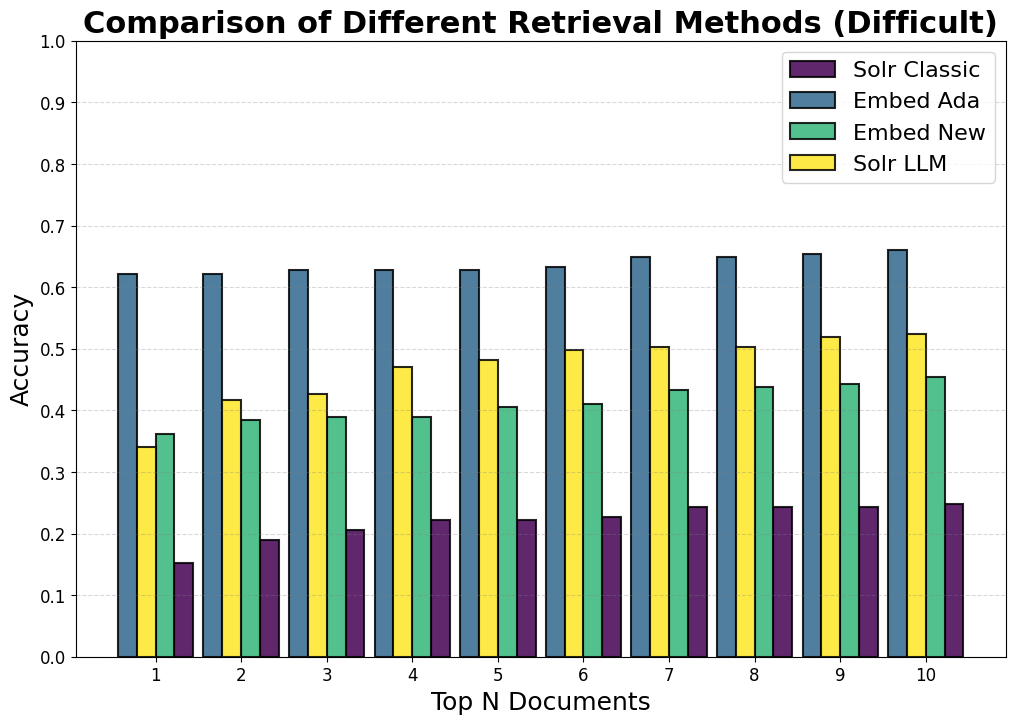

In [92]:
plot_accuracies(N_DOCS, accuracies_solr_difficult, accuracies_embed_ada_difficult, accuracies_embed_new_difficult, accuracies_solr_llm_difficult, title="Difficult")


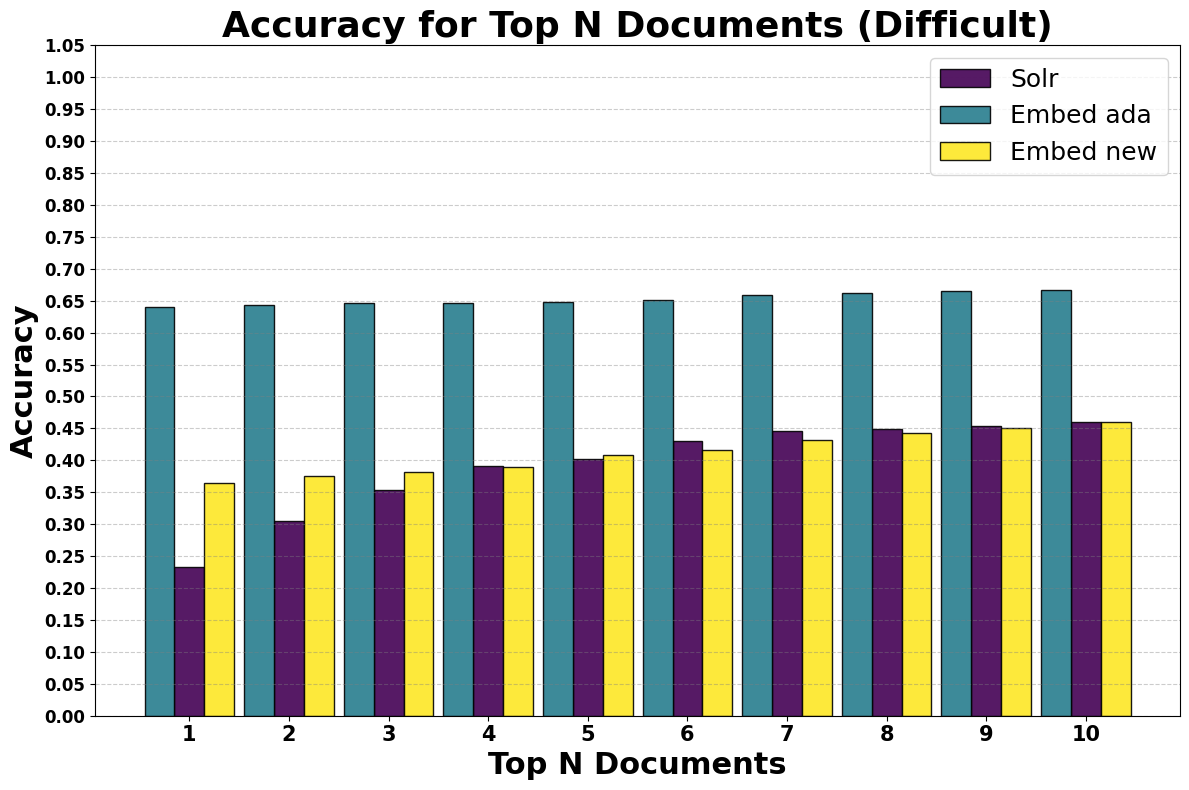

In [56]:
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)  # Array from 1 to 10 for the x-axis

bar_width = 0.3  # Adjusted for 3 bars
positions_embed = n_documents - bar_width  # Left bar
positions_solr = n_documents  # Middle bar
positions_solr_llm = n_documents + bar_width  # Right bar

# Plotting both sets of accuracies
plt.bar(positions_solr, accuracies_solr_difficult, width=bar_width, color='#440154', edgecolor='black', linewidth=1, alpha=0.9, label='Solr')
plt.bar(positions_embed, accuracies_embed_ada_difficult, width=bar_width, color='#287d8e', edgecolor='black', linewidth=1, alpha=0.9, label='Embed ada')
plt.bar(positions_solr_llm, accuracies_embed_new_difficult, width=bar_width, color='#fde725', edgecolor='black', linewidth=1, alpha=0.9, label='Embed new')

plt.title('Accuracy for Top N Documents (Difficult)', fontsize=26, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=22, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=22, fontweight='bold', color='black')

plt.xticks(n_documents, fontsize=15, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.05), fontsize=12, fontweight='bold', color='black')

plt.grid(axis='y', linestyle='--', alpha=0.4, color='grey')


# # Adding value labels on top of each bar
# for i in range(len(n_documents)):
#     plt.text(positions_solr[i], accuracies_solr_difficult[i] + 0.02, f"{accuracies_solr_difficult[i]:.2f}", ha='center', va='bottom', fontsize=9, color='black')
#     plt.text(positions_embed[i], accuracies_embed_ada_difficult[i] + 0.02, f"{accuracies_embed_ada_difficult[i]:.2f}", ha='center', va='bottom', fontsize=9, color='black')
#     plt.text(positions_solr_llm[i], accuracies_embed_new_difficult[i] + 0.02, f"{accuracies_embed_new_difficult[i]:.2f}", ha='center', va='bottom', fontsize=9, color='black')

plt.legend(fontsize=18)
plt.tight_layout()
plt.show()


In [22]:

# result = chain.invoke({'query': query}).content
# print(result)
# params = {
#     "q": result,  # Use the raw query without field specification
#     "defType": "edismax",  # Use the Extended DisMax query parser
#     "qf": "page_content_t",  # Query fields with weights (adjust as needed)
#     "wt": "json",  # Response format (json)
#     "rows": 10,    # Number of rows to return
# }

# # Make the HTTP GET request to Solr
# response = requests.get(solr_url, params=params)

# # Check if the request was successful
# if response.status_code == 200:
#     # Parse the response JSON
#     response_json = response.json()
#     # Extract documents from the response
#     documents = response_json.get("response", {}).get("docs", [])
    
#     # Print the documents
#     print(f"Found {len(documents)} documents matching the query '{query}':")
#     # for doc in documents:
#     #     print(json.dumps(doc, indent=2))
#     # _ = [print(i['title_t']) for i in documents]
# else:
#     print("Failed to query Solr:", response.text)

Mészáros Tamás, tárgy, tanítás
Found 10 documents matching the query 'Milyen tárgyat tanít Mészáros Tamás?':


In [23]:
import matplotlib.pyplot as plt


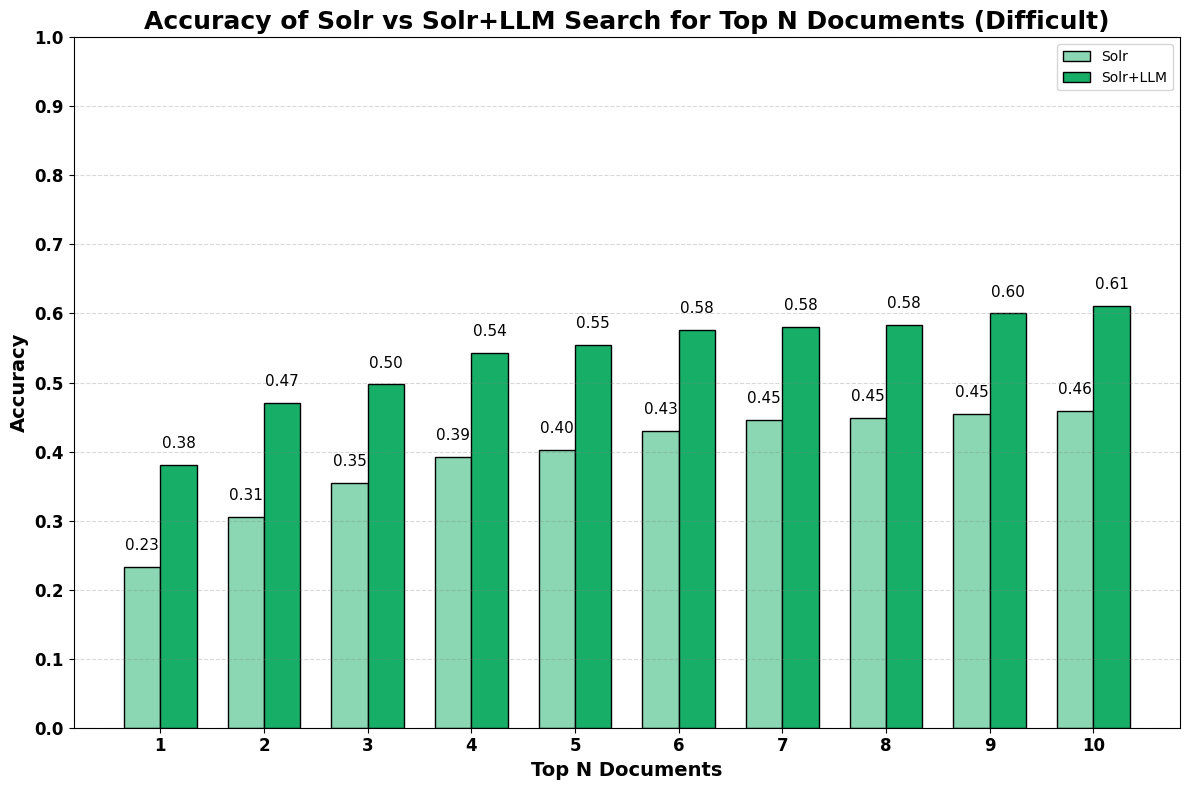

In [24]:
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.35
positions_solr = n_documents - bar_width/2
positions_embed = n_documents + bar_width/2
plt.bar(positions_solr, accuracies_solr_difficult, width=bar_width, color=solr_color, edgecolor='black', linewidth=1, alpha=1, label='Solr')
plt.bar(positions_embed, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Solr vs Solr+LLM Search for Top N Documents (Difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_solr_difficult[i] + 0.02, f"{accuracies_solr_difficult[i]:.2f}", ha='center', va='bottom',fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom',fontsize=11, color='black')
plt.legend()
plt.tight_layout()
plt.show()

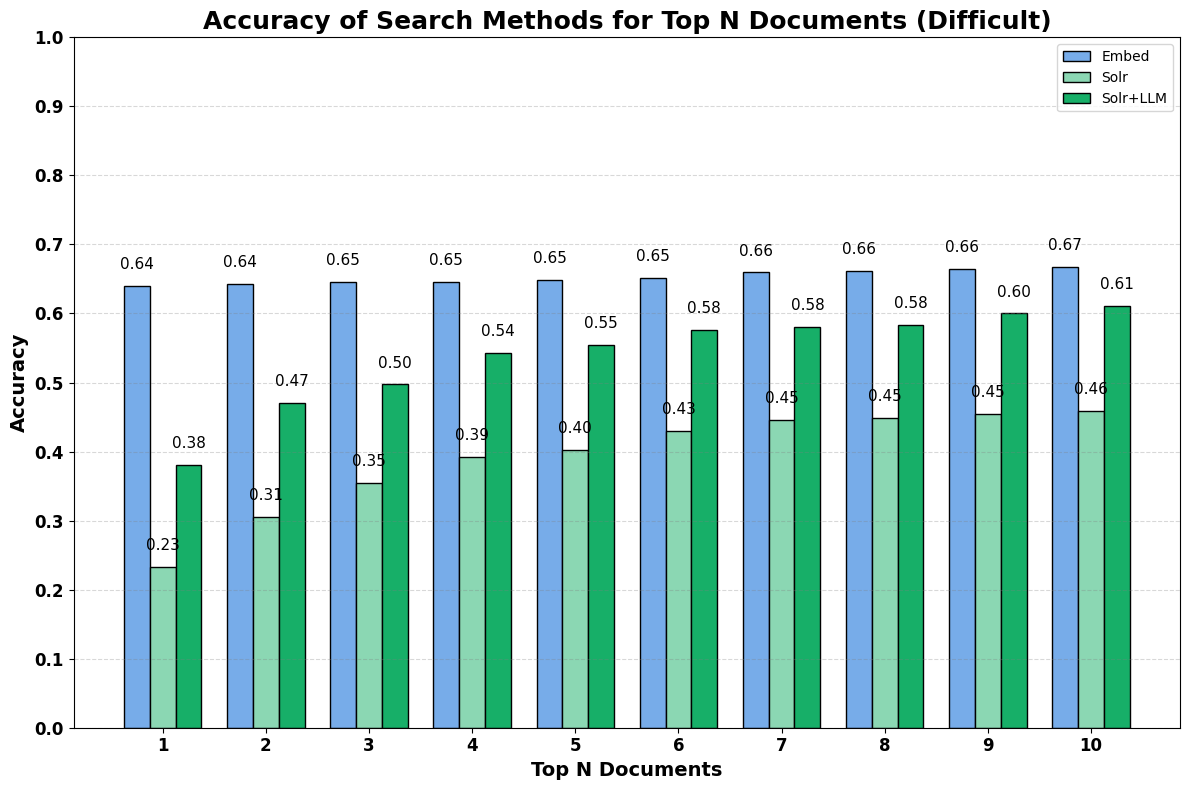

In [25]:
# Set up for the plot
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.25  # Adjusted for 3 bars
positions_embed = n_documents - bar_width  # Left bar
positions_solr = n_documents  # Middle bar
positions_solr_llm = n_documents + bar_width  # Right bar

# Plotting
plt.bar(positions_embed, accuracies_embed_ada_difficult, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed')
plt.bar(positions_solr, accuracies_solr_difficult, width=bar_width, color=solr_color, edgecolor='black', linewidth=1, alpha=1, label='Solr')
plt.bar(positions_solr_llm, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Search Methods for Top N Documents (Difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')

# # Adding value labels on top of each bar
for i in range(len(n_documents)):
    plt.text(positions_embed[i], accuracies_embed_ada_difficult[i] + 0.02, f"{accuracies_embed_ada_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_solr[i], accuracies_solr_difficult[i] + 0.02, f"{accuracies_solr_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_solr_llm[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')

plt.legend()
plt.tight_layout()

plt.show()

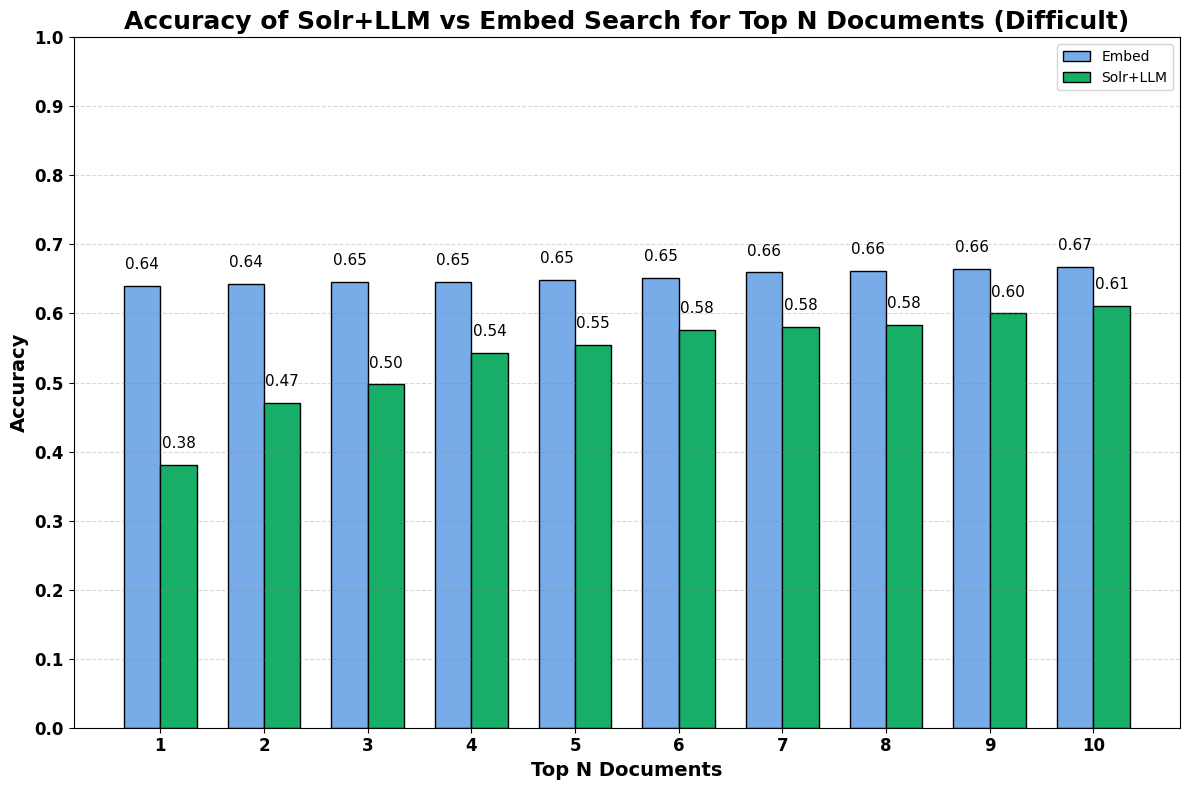

In [26]:
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.35
positions_solr = n_documents - bar_width/2
positions_embed = n_documents + bar_width/2
plt.bar(positions_solr, accuracies_embed_ada_difficult, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed')
plt.bar(positions_embed, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Solr+LLM vs Embed Search for Top N Documents (Difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')  

plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_embed_ada_difficult[i] + 0.02, f"{accuracies_embed_ada_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
import matplotlib.pyplot as plt

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    for question in example["questions"]:
         for query in [question["difficult"], question['question']]:
            params = {
                "q": chain.invoke({'query': query}).content,
                "defType": "edismax",
                "qf": "page_content_t",
                "wt": "json",
                "rows": 8,  # Request the maximum rows once
            }
            response = requests.get(solr_url, params=params)
            if response.status_code == 200:
                response_json = response.json()
                documents = response_json.get("response", {}).get("docs", [])
                docs_vect = vectorstore_ada.max_marginal_relevance_search(query=query, k=2, fetch_k=50)
                titles = [get_title(doc.page_content) for doc in docs_vect]
                titles.append([get_title(doc['page_content_t']) for doc in documents])
                
                
                
                for n in range(1, 11):
                    if title_target in titles[:n]:
                        results[n]['correct'] += 1
                    results[n]['total'] += 1
    
accuracies_solr_emb_difficult_llm = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

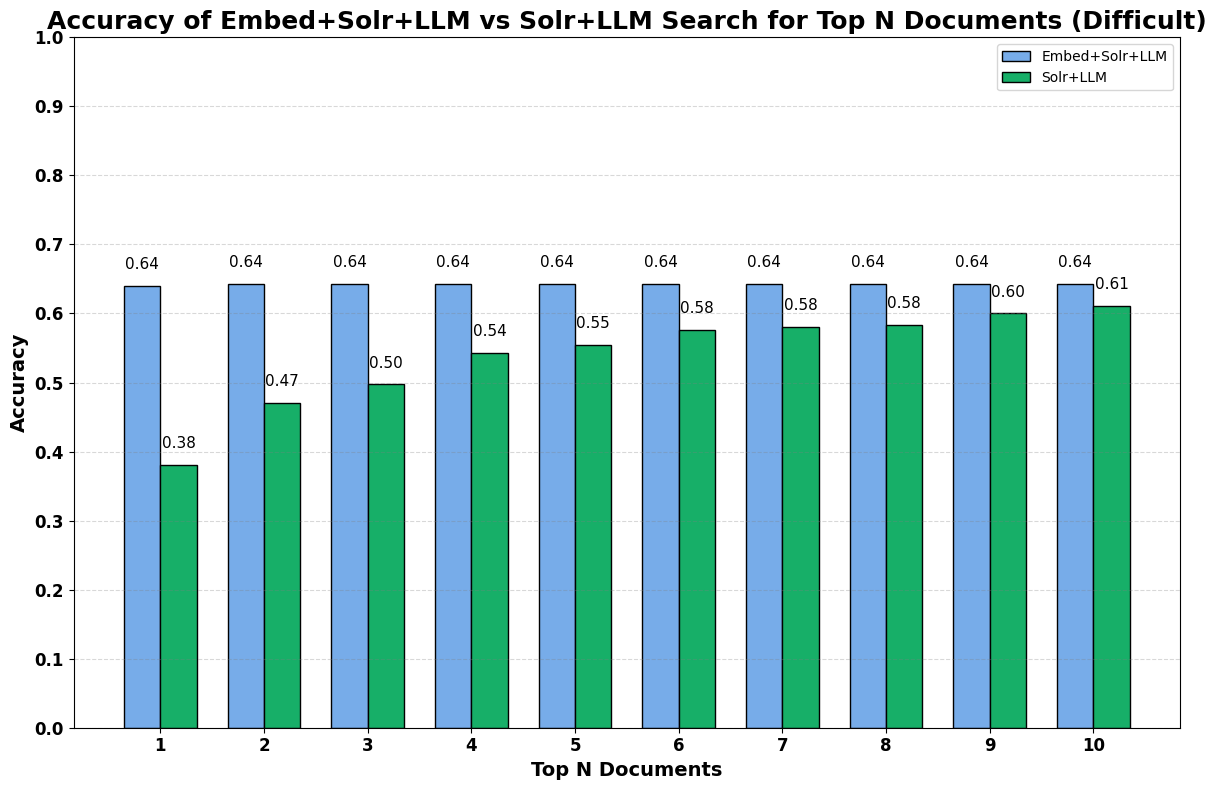

In [28]:
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.35
positions_solr = n_documents - bar_width/2
positions_embed = n_documents + bar_width/2
plt.bar(positions_solr, accuracies_solr_emb_difficult_llm, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed+Solr+LLM')
plt.bar(positions_embed, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Embed+Solr+LLM vs Solr+LLM Search for Top N Documents (Difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')  

plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_solr_emb_difficult_llm[i] + 0.02, f"{accuracies_solr_emb_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
plt.legend()
plt.tight_layout()
plt.show()